In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

INFO: Using numpy backend


In [2]:
import pandas as pd

In [3]:

# define the manifold to be d*d spd matrix, d = 2 
d=6
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=d) 
mfd= sphere.metric


In [4]:
import numpy.fft as fft
import scipy.stats as stats

In [5]:
from tqdm import tqdm_notebook as tqdm

In [5]:
bp0 = np.array([0,0,0,0,0,0,1])

def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1): 
    # generate i.i.d gaussian noise on tangent space 
    size = (n_samples, d) if n_samples != 1 else (1,d)
    
    tangent_vec_aux = sigma*(gs.random.uniform(size=size)-0.5)
    tangent_vec = np.zeros(shape=(n_samples, d+1))
    tangent_vec[:,:d]=tangent_vec_aux
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)



In [6]:
#find or basis of T_p
def Proj(x):
    d = x.shape[0]
    y = np.reshape(x,(d,1))
    return(np.eye(d)-np.dot(y,y.T))

def OR(x):
    #return or basis for T_x S
    P = Proj(x)
    l,u= np.linalg.eig(P)
    idx = l>0.001
    #np.linalg.eig(P)
    return u[:,idx]

def coord(residual,x):
    E = OR(x)
    Y = np.dot(residual,E)
    return(Y)

def mft(Y):
    d = Y.shape[1]
    n = Y.shape[0]
    l = n//2+1
    D  = fft.fft(Y,axis=0)[0:l]/np.sqrt(2*np.pi*n)
  
    return D
    

In [7]:
def generate_ar_ts(base=bp0,n_samples=1,sigma=2,rho=0.5,burn = 500,tau=1):
    # generate AR(1)  process X_t -mu = rho(t/n)(X_{t-1}-mu)+epsilon
    ## rho(u) = 0.3+0.2*u^2
    if n_samples ==1: 
        return generate_random_sample(base,n_samples=1)
    else:
        data_tv =np.zeros((n_samples, d+1))
        delta = generate_sample_tangent_space(base=base, n_samples=1, sigma=1)
        
        for j in range(burn):
            rhotmp =  rho
    
            noise =  generate_sample_tangent_space(base=gs.eye(d), n_samples=1, sigma=sigma)
            delta = rhotmp*delta+noise
            
        data_tv[0,:] =  delta
        
        for i in range(1, n_samples):
            u =i/n_samples
            rhotmp = rho+ tau*(0.2*np.cos(2*u*np.pi)+u*(1-u)) 
            #rhotmp =  rho
            inten = sigma*(0.5 + tau*u**2)
            delta = data_tv[i - 1, :]
            #inten =  sigma*(1+u**2)
            noise = generate_sample_tangent_space(base=gs.eye(d), n_samples=1, sigma=inten)
            data_tv[i,  :] = rhotmp * (delta) + noise
        data =mfd.exp(tangent_vec=data_tv,base_point=base)
        return(data)

In [10]:
tau_lst = [0,0.25,0.5,0.75,1,1.5]
T_lst = [128,256,512,1024]
for a in range(len(tau_lst)):
    for b in range(len(T_lst)):
        tau = tau_lst[a]
        T =T_lst[b]# sample size
        m =  8

        n = T // m  # 64
        repli_s =5000
        L = n//2+1
        u = (n * np.arange(m) + n / 2) / T
        omega = 2 * np.pi * np.arange(1, n + 1) / n
        d = 6
        sigma=1.5
        rho=0.1
        z = np.zeros(repli_s)
        for kk in tqdm(range(repli_s)):
            np.random.seed(kk)
            data = generate_ar_ts(bp0,n_samples=T,sigma=sigma,rho=0.15,burn=500,tau=tau)
            fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
            fmean.fit(data)
            mean =fmean.estimate_
            residual=  mfd.log(point=data,base_point=mean) 

            xx =coord(residual,mean)
            #xx = ar(rho=0.01, T=T, d=6)
            x = xx - np.mean(xx, axis=0)

            D_my = np.zeros((m,L,6),dtype=complex)
            for i in range(m):
                low = i*n
                up = (i+1)*n

                D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)
                #D_my[i] =fft.rfft(x[low:up],axis=0)[0:L]/np.sqrt(2*np.pi*n)
            D_my_conj = np.conj(D_my)
            D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

            #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
            inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)
            #inner_products2 = np.sum(D_conj[:,1:L,:] * D[:, 1:L, :], axis=2)
            F1hat =  np.sum(np.square(np.abs(inner_products)))/T

            V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
            V_conj_transpose = np.conj(V)  # This is the complex conjugate 

            # Prepare the arrays for outer product calculation using broadcasting
            # Add a new axis to V for broadcasting to work correctly for the outer product
            V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
            V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :]  # This will have the shape (16, 8, 1, 6)

            # Now compute the outer product
            Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

            Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
            Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

            F2hat= Il_sq.mean()/2
            Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
            mhat = (F1hat-F2hat+Bhat/m)
            #mhat = F1_hat-F2_hat
            vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/n)
            z[kk] = np.sqrt(T)*mhat/vhat

        np.save('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy',z)
        print(np.mean(z>stats.norm.ppf(0.95)))

/var/folders/xl/kgnxbxpd1tl1dxlkp0qvtb180000gn/T/ipykernel_63565/468599825.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kk in tqdm(range(repli_s)):


  0%|          | 0/5000 [00:00<?, ?it/s]

0.1294


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0904


  0%|          | 0/5000 [00:00<?, ?it/s]

0.071


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0644


  0%|          | 0/5000 [00:00<?, ?it/s]

0.2784


  0%|          | 0/5000 [00:00<?, ?it/s]

0.2644


  0%|          | 0/5000 [00:00<?, ?it/s]

0.3036


  0%|          | 0/5000 [00:00<?, ?it/s]

0.403


  0%|          | 0/5000 [00:00<?, ?it/s]

0.5632


  0%|          | 0/5000 [00:00<?, ?it/s]

0.631


  0%|          | 0/5000 [00:00<?, ?it/s]

0.7714


  0%|          | 0/5000 [00:00<?, ?it/s]

0.917


  0%|          | 0/5000 [00:00<?, ?it/s]

0.7724


  0%|          | 0/5000 [00:00<?, ?it/s]

0.8488


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9438


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9924


  0%|          | 0/5000 [00:00<?, ?it/s]

0.891


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9266


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9766


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9992


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9492


  0%|          | 0/5000 [00:00<?, ?it/s]

0.965


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9914


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9998


In [37]:
zlst

[(0, 128, 0.1294)]

In [8]:
tau_lst = [0,0.25,0.5,0.75,1,1.5]
T_lst = [256,512,1024]
m_lst = [8]

repli_s =5000

sigma=1.5
d_intrinsic = 6 # dimension 
rho=0.1
zlst = []
for a in range(len(tau_lst)):
    for b in range(len(T_lst)):
        for c in range(len(m_lst)):
            tau = tau_lst[a]
            T =T_lst[b]# sample size
            m=m_lst[c]
            znow = np.load('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy')
            znow=np.mean(znow>stats.norm.ppf(0.95))
            zlst.append((tau, T, znow))

In [9]:
zlst

[(0, 256, 0.0904),
 (0, 512, 0.071),
 (0, 1024, 0.0644),
 (0.25, 256, 0.2644),
 (0.25, 512, 0.3036),
 (0.25, 1024, 0.403),
 (0.5, 256, 0.631),
 (0.5, 512, 0.7714),
 (0.5, 1024, 0.917),
 (0.75, 256, 0.8488),
 (0.75, 512, 0.9438),
 (0.75, 1024, 0.9924),
 (1, 256, 0.9266),
 (1, 512, 0.9766),
 (1, 1024, 0.9992),
 (1.5, 256, 0.965),
 (1.5, 512, 0.9914),
 (1.5, 1024, 0.9998)]

In [35]:
 #znow = np.load('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy')

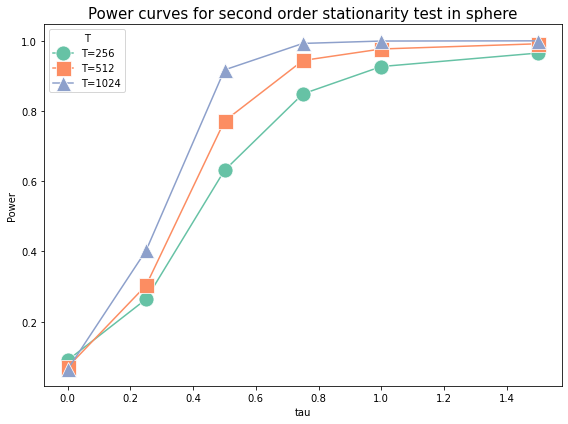

In [10]:
z_array = np.array(zlst, dtype=[('tau', 'f4'), ('T', 'f4'), ('z', 'f4')])

# Creating a DataFrame for seaborn
z_df = pd.DataFrame(z_array)
palette = sns.color_palette("Set2")  # You can choose other palettes
markers = ["o", "s", "^", "D", "x", "*", "P"]  # Different marker styles
plt.figure(figsize=(8, 6))
for i, (T, grp) in enumerate(z_df.groupby('T')):
    sns.lineplot(data=grp, x='tau', y='z', label=f'T={int(T)}',
                 color=palette[i % len(palette)], marker=markers[i % len(markers)],markersize=15)

plt.title('Power curves for second order stationarity test in sphere', fontsize=15)
plt.xlabel('tau')
plt.ylabel('Power')
plt.legend(title='T')
plt.tight_layout()
plt.savefig('Second_order_sphere.png',facecolor='w')

In [14]:
z_array

array([(0.  ,  128., 0.1294), (0.  ,  256., 0.0904),
       (0.  ,  512., 0.071 ), (0.  , 1024., 0.0644),
       (0.25,  128., 0.2784), (0.25,  256., 0.2644),
       (0.25,  512., 0.3036), (0.25, 1024., 0.403 ),
       (0.5 ,  128., 0.5632), (0.5 ,  256., 0.631 ),
       (0.5 ,  512., 0.7714), (0.5 , 1024., 0.917 ),
       (0.75,  128., 0.7724), (0.75,  256., 0.8488),
       (0.75,  512., 0.9438), (0.75, 1024., 0.9924),
       (1.  ,  128., 0.891 ), (1.  ,  256., 0.9266),
       (1.  ,  512., 0.9766), (1.  , 1024., 0.9992),
       (1.5 ,  128., 0.9492), (1.5 ,  256., 0.965 ),
       (1.5 ,  512., 0.9914), (1.5 , 1024., 0.9998)],
      dtype=[('tau', '<f4'), ('T', '<f4'), ('z', '<f4')])

In [8]:
z_mat = np.zeros((5000,4))
T_lst = [64,128,256,512]
for l in range(4):
    T= T_lst[l]
    z_mat[:,l]=np.load('zval_sigma_'+str(1.5)+'rho_'+str(0.15)+'T_'+str(T)+'m_'+str(8)+'_AR_power.npy')


In [9]:
np.mean(z_mat>=stats.norm.ppf(0.95),axis=0)

array([0.789 , 0.882 , 0.9264, 0.9756])